1. First, use OSMnx to retrieve the road network specified by the study area.

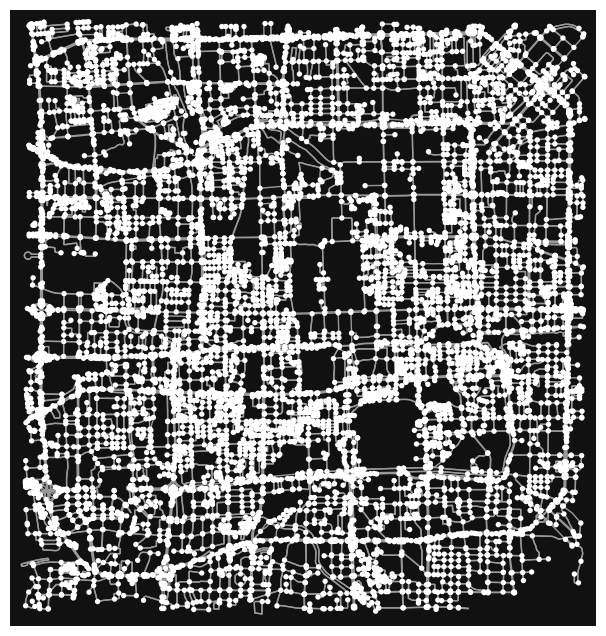

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [11]:
import osmnx as ox

# Download the road network
G = ox.graph_from_bbox(39.84, 39.97, 116.30, 116.46, network_type='drive')
# Project the graph
G_projected = ox.project_graph(G)
# Plot the graph
ox.plot_graph(G_projected)

This looks too complicated, so the upcoming graphs will not display nodes for now. 

The code for the upcoming parts will be provided in another separate file in its complete version.

2. Calculate the length of each edge, then add it as an attribute.

In [ ]:
import osmnx as ox
import networkx as nx
import random
import pandas as pd

# Download the road network
G = ox.graph_from_bbox(39.84, 39.97, 116.30, 116.46, network_type='drive')

# Calculate the length of each edge and add it as an attribute
for u, v, k, data in G.edges(keys=True, data=True):
    data['length'] = data.get('length', ox.distance.great_circle_vec(G.nodes[u]['y'], G.nodes[u]['x'], G.nodes[v]['y'], G.nodes[v]['x']))

3. Get arbitrarily two vertices in the road network.

In [ ]:
# Get a random start and end node
nodes = list(G.nodes())
node1 = random.choice(nodes)
node2 = random.choice(nodes)

# Get the latitude and longitude of the start and end nodes
node1_lat_lon = (G.nodes[node1]['y'], G.nodes[node1]['x'])
node2_lat_lon = (G.nodes[node2]['y'], G.nodes[node2]['x'])

4. Use the shortest path query provided by NetworkX to get the result.

In [ ]:
shortest_path = nx.shortest_path(G, node1, node2, weight='length')
length = nx.shortest_path_length(G, node1, node2, weight='length')

5. Then plot the shortest path along with its start and end nodes in the road network.

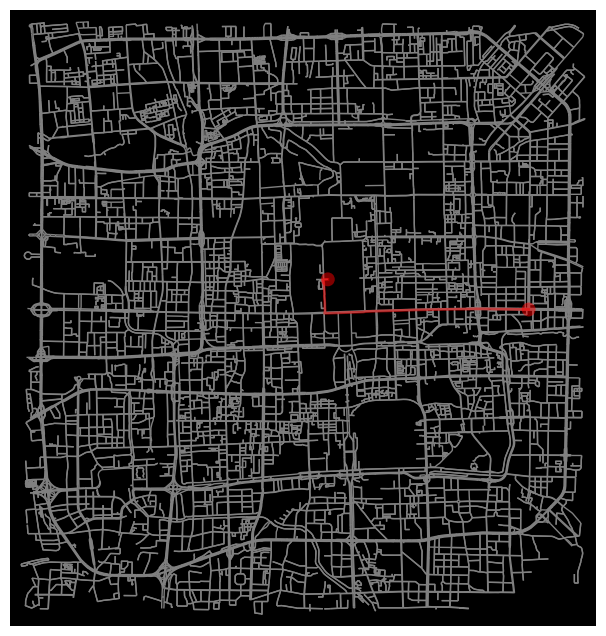

In [6]:
# FIGURE 1
# Project the graph
G_projected = ox.project_graph(G)

# Plot the graph
fig, ax = ox.plot_graph(G_projected, node_size=0, edge_color='grey', bgcolor='k', show=False, close=False)

# Plot the shortest path
path_edges = list(zip(shortest_path, shortest_path[1:]))
ox.plot.plot_graph_route(G_projected, shortest_path, route_color='r', route_linewidth=2, node_size=0, ax=ax)

# Plot the start and end nodes
node_positions = {node: (G_projected.nodes[node]['x'], G_projected.nodes[node]['y']) for node in shortest_path}
nx.draw_networkx_nodes(G_projected, pos=node_positions, ax=ax, nodelist=[node1, node2], node_color='blue', node_size=10)

It looks like there are too many routes that are not relevant to the shortest path. Next, I will plot a simplified graph.

6. Output the latitude and longitude of arbitrary nodes, the length of the shortest path, and the number of edges that make up the shortest path.

In [7]:
# OUTPUT 1
# Print nodes and shortest path length
print("Node 1:", node1_lat_lon)
print("Node 2:", node2_lat_lon)
print("Shortest path length:", length, "m")

# Output the number of edges in the shortest path
print("Number of edges in the shortest path:", len(path_edges))

Node 1: (39.9134115, 116.3864023)
Node 2: (39.9070359, 116.4441178)
Shortest path length: 5936.602000000001 m
Number of edges in the shortest path: 32


7. Number each edge that makes up the shortest path and add a new attribute 'Edge ID' to each edge.

In [ ]:
# Add 'edge_ID' attribute to each edge in the shortest path
edge_id = 1
for u, v in zip(shortest_path[:-1], shortest_path[1:]):
    G[u][v][0]['edge_ID'] = edge_id
    edge_id += 1

8. Output a table containing the Edge ID, length, and highway type of each edge that makes up the shortest path.

In [8]:
# TABLE 1 (edges and attributes table)
data_list = []
for u, v in path_edges:
    data = G[u][v][0]
    highway_type = data.get('highway', 'N/A')
    length = data.get('length', 'N/A')
    edge_id = data.get('edge_ID', 'N/A')
    data_list.append({"Edge ID": edge_id, "Highway Type": highway_type, "Length": length})

# Create a DataFrame from the data list
df = pd.DataFrame(data_list, columns=["Edge ID", "Highway Type", "Length"])

# Output the DataFrame
df

,Edge ID,Highway Type,Length
0,1,unclassified,104.331
1,2,tertiary,229.131
2,3,tertiary,481.749
3,4,tertiary,94.416
4,5,tertiary,28.126
5,6,primary,332.586
6,7,primary,310.228
7,8,primary,323.552
8,9,primary,290.960
9,10,primary,23.596


9. Reorganize the original table, categorize the edges by highway type, and calculate the total length for each highway type.

In [9]:
# TABLE 2
# Group edges by "Highway Type" and sum the lengths
grouped_df = df.groupby("Highway Type").agg({"Edge ID": lambda x: ', '.join(map(str, x)), "Length": "sum"})

# Output the grouped DataFrame
grouped_df

,Edge ID,Length
Highway Type,,
primary,"6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18...",3835.977
tertiary,"2, 3, 4, 5",833.422
trunk,"27, 28, 29, 30, 31, 32",1162.872
unclassified,1,104.331


In [ ]:
10. Output a simplified road network to zoom in on the shortest path, providing a clearer view of the route and nodes.

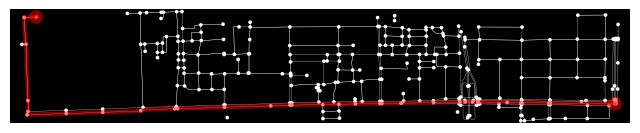

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [10]:
# FIGURE 2
# Determine the bounding box of the shortest path
min_lat = min(G.nodes[node]['y'] for node in shortest_path)
max_lat = max(G.nodes[node]['y'] for node in shortest_path)
min_lon = min(G.nodes[node]['x'] for node in shortest_path)
max_lon = max(G.nodes[node]['x'] for node in shortest_path)

# Expand the bounding box to include surrounding nodes
buffer = 0.0005  # Adjust this value as needed
min_lat -= buffer
max_lat += buffer
min_lon -= buffer
max_lon += buffer

# Find nodes within the expanded bounding box
surrounding_nodes = [node for node in G.nodes() if min_lat <= G.nodes[node]['y'] <= max_lat and min_lon <= G.nodes[node]['x'] <= max_lon]

# Create a subgraph containing the shortest path and surrounding nodes
surrounding_graph = G.subgraph(surrounding_nodes)

# Project the subgraph
surrounding_graph_projected = ox.project_graph(surrounding_graph)
# Plot the subgraph
fig, ax = ox.plot_graph(surrounding_graph_projected, node_size=7, node_color='white', edge_color='white', edge_linewidth=0.2, bgcolor='black', show=False, close=False)
# Plot the shortest path
ox.plot.plot_graph_route(surrounding_graph_projected, shortest_path, route_color='r', route_linewidth=3, node_size=5, node_color='white', ax=ax)

Some areas for improvement: 
I suggest using draw_networkx_labels to label each edge's Edge ID that makes up the shortest path on the graph. This way, you can reference TABLE 2 to determine the highway type of a segment in the shortest path.